In [48]:
import pandas as pd
import numpy as np
from numpy import random
import os
import matplotlib.pyplot as plt

In [49]:
labels = [
    'animal', 'cartoon', 'floral', 'geometry', 'ikat',
    'plain', 'polka dot', 'squares', 'stripes', 'tribal'
]

In [50]:
def read_data(folder):
    label_list = []
    path_list = []

    for class_name in labels:
        class_path = os.path.join(folder, class_name)
        if not os.path.exists(class_path):
            continue
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            label_list.append(class_name)
            path_list.append(image_path)

    return label_list, path_list

In [51]:
directory = r'C:\Users\Lenovo\OneDrive\Documents\ndn\Internship\SmartBridgeAIML\PatternSense-FabricPatternsUsingDL\data_pattern'

In [52]:
all_labels, all_paths = read_data(directory)

df = pd.DataFrame({
    'path': all_paths,
    'label': all_labels
})

df.head()


,path,label
0,C:\Users\Lenovo\OneDrive\Documents\ndn\Interns...,animal
1,C:\Users\Lenovo\OneDrive\Documents\ndn\Interns...,animal
2,C:\Users\Lenovo\OneDrive\Documents\ndn\Interns...,animal
3,C:\Users\Lenovo\OneDrive\Documents\ndn\Interns...,animal
4,C:\Users\Lenovo\OneDrive\Documents\ndn\Interns...,animal


In [53]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% dummy (to be split into test and validation)
train_df, dummy_df = train_test_split(
    df,
    train_size=0.8,
    random_state=123,
    shuffle=True,
    stratify=df['label']
)

# Second split: dummy_df → 50% validation, 50% test
valid_df, test_df = train_test_split(
    dummy_df,
    train_size=0.5,
    random_state=123,
    shuffle=True,
    stratify=dummy_df['label']
)

# Display the split info
print("Train dataset:", len(train_df),
      "Test dataset:", len(test_df),
      "Validation dataset:", len(valid_df))

# Class distribution in train set
train_balance = train_df['label'].value_counts()
print("Train dataset value count:\n", train_balance)


Train dataset: 3384 Test dataset: 423 Validation dataset: 423
Train dataset value count:
 label
stripes      400
polka dot    398
plain        398
tribal       397
floral       396
squares      351
ikat         284
animal       281
geometry     271
cartoon      208
Name: count, dtype: int64


In [54]:
import os
directory = r'C:\Users\Lenovo\OneDrive\Documents\ndn\Internship\SmartBridgeAIML\PatternSense-FabricPatternsUsingDL\data_pattern'
labels = os.listdir(directory)
print("Labels before sorting:", labels)
labels.sort()
print("Labels after sorting:", labels)


Labels before sorting: ['animal', 'cartoon', 'floral', 'geometry', 'ikat', 'plain', 'polka dot', 'squares', 'stripes', 'tribal']
Labels after sorting: ['animal', 'cartoon', 'floral', 'geometry', 'ikat', 'plain', 'polka dot', 'squares', 'stripes', 'tribal']


# Image Augmentation

In [55]:
import plotly.express as px
px.histogram(train_df, x='label', barmode='group')


In [56]:
import cv2

#Defining the augmentation function

In [57]:
def apply_transform(image):

    # Rotate (random angle between -40 and 40 degrees)
    angle = np.random.uniform(-40, 40)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows))

    # Horizontal Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)

    # Vertical Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)

    # Random Brightness and Contrast
    alpha = 1.0 + np.random.uniform(-0.2, 0.2)  # Brightness
    beta = 0.0 + np.random.uniform(-0.2, 0.2)   # Contrast
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Random Gamma Correction
    gamma = np.random.uniform(0.8, 1.2)
    image = np.clip((image / 255.0) ** gamma, 0, 1) * 255.0

    return image


In [58]:
def apply_augmentation(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented_image = apply_transform(image=image)
    return augmented_image, label

# Image Preprocessing

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [60]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 8. Create Generators
IMG_SIZE = (255, 255)
BATCH_SIZE = 32
SEED = 12

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    seed=SEED,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    seed=SEED,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    seed=SEED,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 3384 validated image filenames belonging to 10 classes.
Found 423 validated image filenames belonging to 10 classes.
Found 423 validated image filenames belonging to 10 classes.


# ✅ Model Building

In [61]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam, Adamax
import tensorflow as tf

# ✅ Full Model Building & Compilation Code (Custom CNN for Multi-class Classification)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Step 1: Create the model
model = Sequential()

# Conv Block 1
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(255, 255, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

# Conv Block 2
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

# Conv Block 3
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))

# Conv Block 4
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

# Flatten & Dense Layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Use 10 if you have 10 classes

# Step 2: Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Step 3: Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model_cnn.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Step 4: Show model summary
model.summary()

c:\Users\Lenovo\.conda\envs\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 63, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 31, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,928,650 (14.99 MB)

 Trainable params: 3,928,650 (14.99 MB)

 Non-trainable params: 0 (0.00 B)

# Train and Evaluate the Model

In [17]:
# Step 3: Train the model

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,                    # you can adjust based on performance
    verbose=1,
    shuffle=True,
    callbacks=[checkpoint]
)


c:\Users\Lenovo\.conda\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1102 - loss: 2.3604
Epoch 1: val_accuracy improved from -inf to 0.17494, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.1104 - loss: 2.3599 - val_accuracy: 0.1749 - val_loss: 2.2691
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1793 - loss: 2.2107
Epoch 2: val_accuracy improved from 0.17494 to 0.18676, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.1794 - loss: 2.2106 - val_accuracy: 0.1868 - val_loss: 2.1803
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1978 - loss: 2.1666
Epoch 3: val_accuracy did not improve from 0.18676
106/106 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.1979 - loss: 2.1666 - val_accuracy: 0.1844 - val_loss: 2.1308
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2112 - loss: 2.1228
Epoch 4: val_accuracy improved from 0.18676 to 0.20804, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.2112 - loss: 2.1228 - val_accuracy: 0.2080 - val_loss: 2.1588
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2367 - loss: 2.1101
Epoch 5: val_accuracy improved from 0.20804 to 0.21986, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.2367 - loss: 2.1100 - val_accuracy: 0.2199 - val_loss: 2.1021


# Add ResNet50 Initialization

In [63]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(255, 255, 3)
)

print("✅ Created ResNet50 base model")

✅ Created ResNet50 base model


# Adding Dense Layers and Compiling the Model

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# 1. Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# 2. Unfreeze some of the deeper layers for fine-tuning (optional)
for layer in base_model.layers[173:]:
    layer.trainable = True

# 3. Add custom layers on top of base_model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten while reducing parameters

x = Dense(1024, activation='relu', kernel_initializer="he_uniform")(x)
x = Dropout(0.4)(x)

x = Dense(512, activation='relu', kernel_initializer="he_uniform")(x)
x = Dropout(0.4)(x)

prediction = Dense(10, activation='softmax')(x)

# 4. Build final model
final_model = Model(inputs=base_model.input, outputs=prediction)

# 5. Compile the model
final_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# 6. ModelCheckpoint callback
model_checkpoint_callback_rs = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_resnet50.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


# create callbacks

In [65]:
# Compile the model 
final_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# ModelCheckpoint callback (already defined earlier)
model_checkpoint_callback_rs = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_resnet50.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

#EarlyStopping callback - stops training when val_accuracy stops improving
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

#ReduceLROnPlateau - reduce learning rate if model plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Combine all callbacks
callbacks_list = [model_checkpoint_callback_rs, early_stop, reduce_lr]


# Training the model

In [21]:
history_resnet = final_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=3,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1202 - loss: 2.6478
Epoch 1: val_accuracy improved from -inf to 0.13002, saving model to model_resnet50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.1203 - loss: 2.6458 - val_accuracy: 0.1300 - val_loss: 2.2497 - learning_rate: 0.0010
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1514 - loss: 2.2677
Epoch 2: val_accuracy improved from 0.13002 to 0.16548, saving model to model_resnet50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.1514 - loss: 2.2677 - val_accuracy: 0.1655 - val_loss: 2.2221 - learning_rate: 0.0010
Epoch 3/3
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1588 - loss: 2.2432
Epoch 3: val_accuracy did not improve from 0.16548
106/106 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.1589 - loss: 2.2431 - val_accuracy: 0.1418 - val_loss: 2.1977 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


# Evaluating the model

# Visualize Model Performance

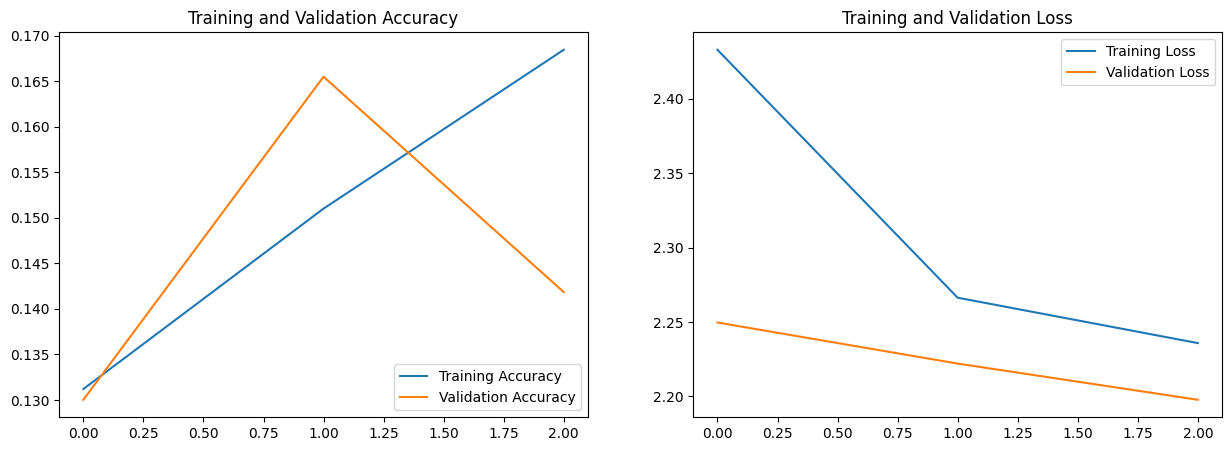

In [66]:
import matplotlib.pyplot as plt
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(len(acc))  # Automatically adjusts to number of epochs

# Plot Accuracy and Loss
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Confusion Matrix and Classification Report 

c:\Users\Lenovo\.conda\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step
There were 374 errors in 423 tests for an accuracy of 11.58%


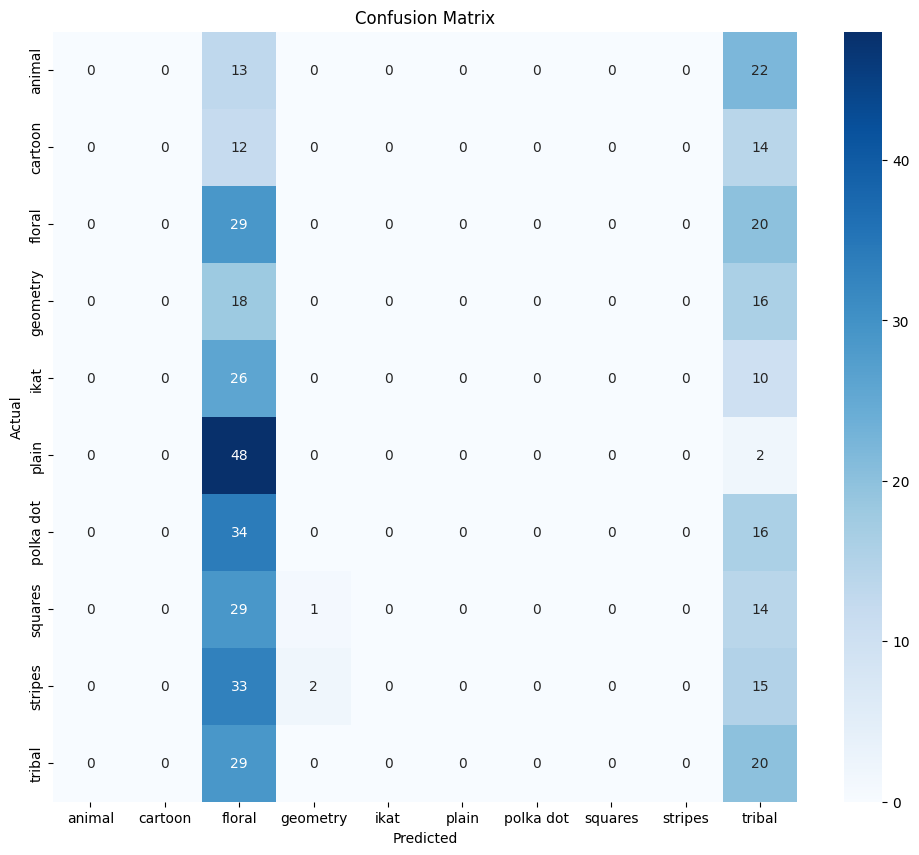

Classification Report:
               precision    recall  f1-score   support

      animal     0.0000    0.0000    0.0000        35
     cartoon     0.0000    0.0000    0.0000        26
      floral     0.1070    0.5918    0.1812        49
    geometry     0.0000    0.0000    0.0000        34
        ikat     0.0000    0.0000    0.0000        36
       plain     0.0000    0.0000    0.0000        50
   polka dot     0.0000    0.0000    0.0000        50
     squares     0.0000    0.0000    0.0000        44
     stripes     0.0000    0.0000    0.0000        50
      tribal     0.1342    0.4082    0.2020        49

    accuracy                         0.1158       423
   macro avg     0.0241    0.1000    0.0383       423
weighted avg     0.0279    0.1158    0.0444       423



c:\Users\Lenovo\.conda\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Lenovo\.conda\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Lenovo\.conda\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [46]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(model, test_gen):
    # Get class labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    preds = model.predict(test_gen, verbose=1)

    # Get predicted indices
    pred_indices = [np.argmax(p) for p in preds]
    y_pred = np.array(pred_indices, dtype="int")

    # Get true labels
    y_true = np.array(test_gen.labels, dtype="int")

    # Calculate accuracy
    errors = np.sum(y_pred != y_true)
    test_count = len(y_true)
    accuracy = (test_count - errors) * 100 / test_count
    msg = f"There were {errors} errors in {test_count} tests for an accuracy of {accuracy:.2f}%"
    print(msg)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n", clr)
predictor(final_model, test_gen)

# Manual Testing

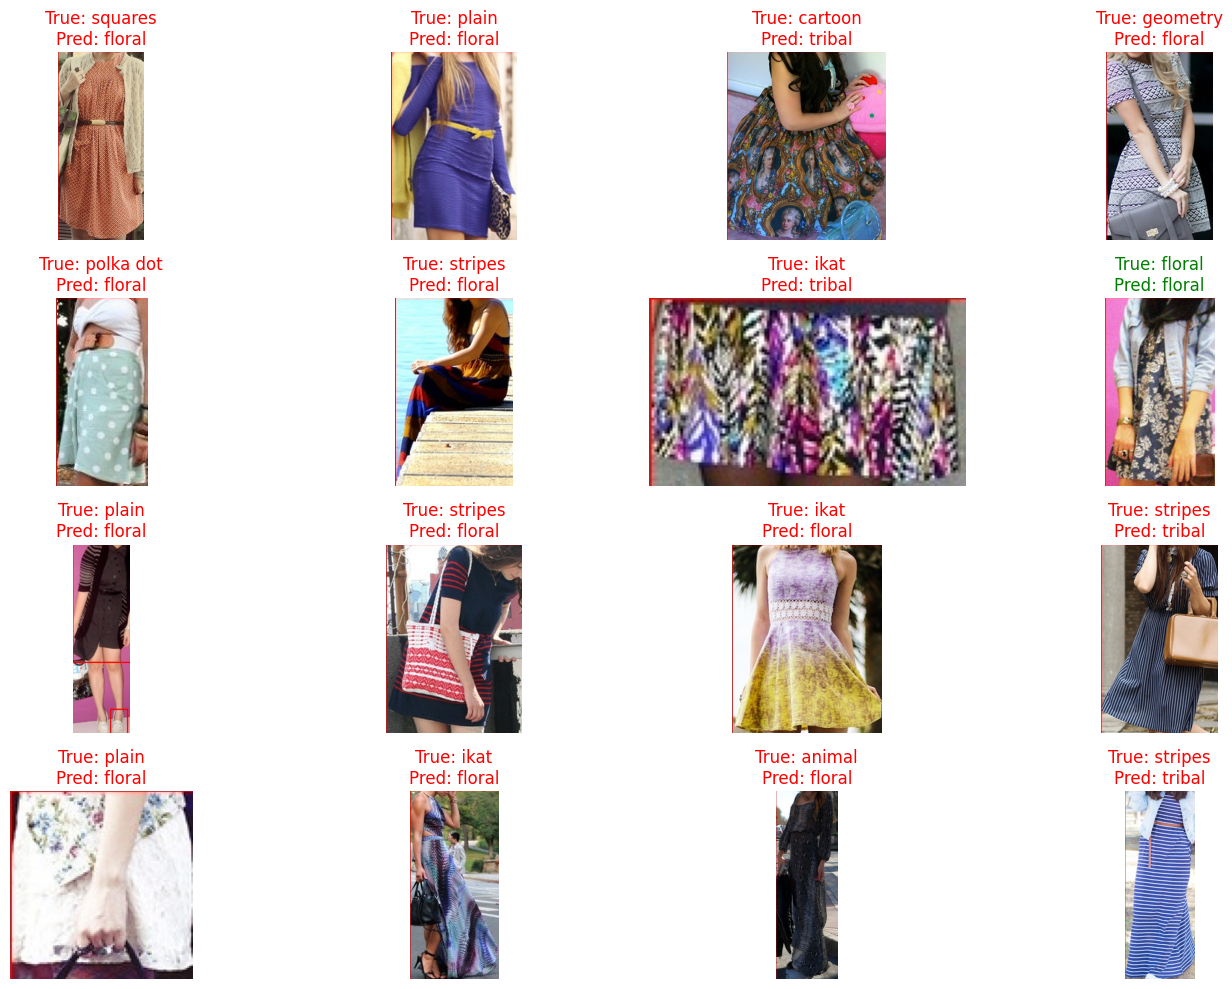

In [47]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define the manual prediction function
def get_model_prediction(image_path):
    img = load_img(image_path, target_size=(255, 255))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # match preprocessing used during training
    predictions = final_model.predict(x, verbose=0)
    return list(test_gen.class_indices.keys())[predictions.argmax()]

# Step 2: Make predictions on the entire test set
pred = [get_model_prediction(file) for file in test_df['path'].values]

# Step 3: Visualize 16 random predictions
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
random_indices = np.random.randint(0, len(test_df), 16)

for i, ax in enumerate(axes.ravel()):
    img_path = test_df['path'].iloc[random_indices[i]]
    true_label = test_df['label'].iloc[random_indices[i]]
    predicted_label = pred[random_indices[i]]
    
    img = load_img(img_path)
    ax.imshow(img)
    ax.axis('off')

    color = "green" if predicted_label == true_label else "red"
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()
